In [1]:
import pickle, os, torch
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score

In [5]:
folder = 'results_sweep_feats_150122'

run='Sage_vlarge_all_4t_z0.0_quantile_raw_wqagsf_1_2'

In [8]:
pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    

In [356]:
results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))

In [357]:
ys, pred, targets = results['low_ys'], results['low_pred'], config["data_params"]['targets']

In [358]:
results.keys()

dict_keys(['sigma', 'test_acc', 'train_acc', 'ys', 'pred', 'low_ys', 'low_pred', 'low', 'epochexit'])

In [359]:
cols_t=np.array(['M_star', 'v_disk', 'm_cold gas', 'sfr_ave100Myr'])
    
def multi_base(ys, pred, targets):
    n_t = len(targets)
    figs=[]
    for n in range(n_t):
        fig, ax =plt.subplots(1,2, figsize=(12,6))
        ax=ax.flatten()
        ax[0].plot(ys[:,n],pred[:,n], 'ro', alpha=0.3)
        ax[0].plot([min(ys[:,n]),max(ys[:,n])],[min(ys[:,n]),max(ys[:,n])], 'k--', label='Perfect correspondance')
        ax[0].set(xlabel='SAM Truth',ylabel='GNN Prediction', title=cols_t[targets[n]])
        yhat=r'$\hat{y}$'
        ax[0].text(0.6,0.15, f'Bias (mean(y-{yhat})) : {np.mean(ys[:,n]-pred[:,n]):.3f}', transform=ax[0].transAxes)
        ax[0].text(0.6,0.1, r'$\sigma$ :  '+f'{np.std(ys[:,n]-pred[:,n]):.3f}', transform=ax[0].transAxes)
        ax[0].legend()
        vals, x, y, _ =ax[1].hist2d(ys[:,n],pred[:,n],bins=50, norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
        X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
        ax[1].contour(X,Y, np.log(vals.T+1), levels=10, colors='black')
        ax[1].plot([min(ys[:,n]),max(ys[:,n])],[min(ys[:,n]),max(ys[:,n])], 'k--', label='Perfect correspondance')
        ax[1].set(xlabel='SAM Truth',ylabel='GNN Prediction', title=cols_t[targets[n]])
        ax[1].legend()
        fig.tight_layout()
        figs.append(fig)
    return figs

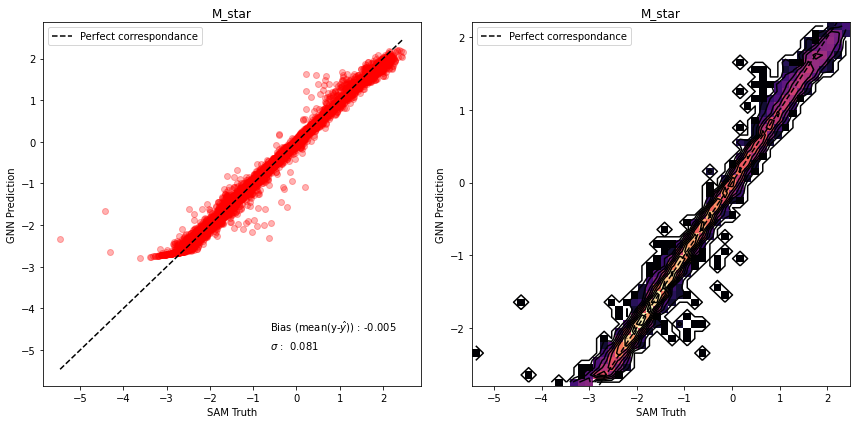

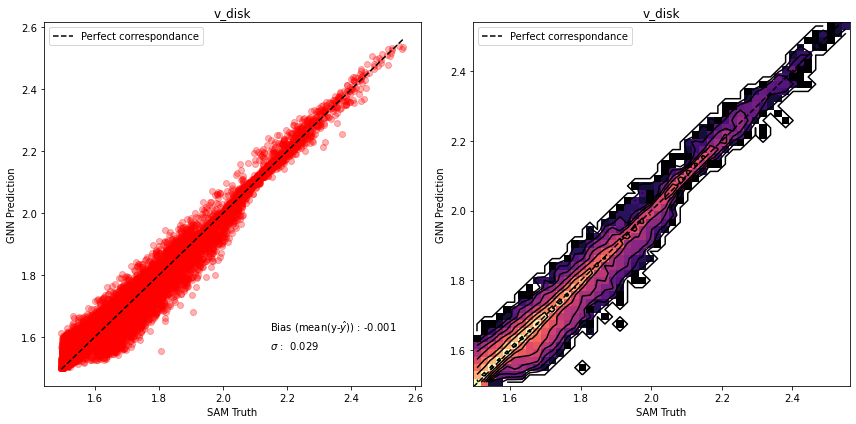

In [360]:
figs=multi_base(ys,pred, targets)

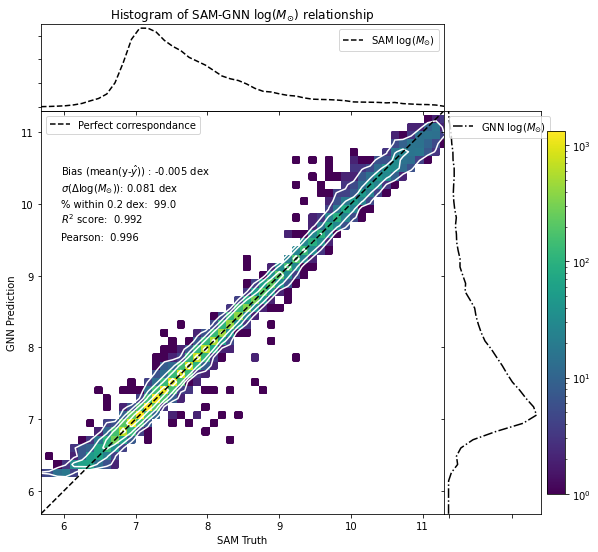

In [361]:
from matplotlib.ticker import NullFormatter
from scipy import stats

ys[:,0]+=9
pred[:,0]+=9

n=0
target=r"log($M_{\odot}$)"
# target=r"$v_{disk}$"

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.7
bottom, height = 0.1, 0.7
bottom_h = left_h = left + width
# rect_Cbar = [0, bottom, 0.1, height]
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.15]
rect_histy = [left_h, bottom, 0.15+0.06, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))
# axCbar = plt.axes(rect_Cbar)
axHist = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(nullfmt)
axHisty.xaxis.set_major_formatter(nullfmt)

bins=50
l=0.01
xt=0.05
yt=0.8
n_contour=4
# the scatter plot:
vals, x, y, hist =axHist.hist2d( ys[:,n], pred[:,n],bins=bins, range=[np.percentile(np.hstack([ys[:,n],pred[:,n]]), [0+l,100-l]),
                            np.percentile(np.hstack([ys[:,n],pred[:,n]]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
axHist.plot([min(ys[:,n]),max(ys[:,n])],[min(ys[:,n]),max(ys[:,n])], 'k--', label='Perfect correspondance')
axHist.set(xlabel='SAM Truth',ylabel='GNN Prediction')
axHist.legend()

# now determine nice limits by hand:
X, Y = X[0], Y.T[0]
axHist.set_xlim((min(X), max(X)))
axHist.set_ylim((min(Y), max(Y)))
yhat=r'$\hat{y}$'
pct=np.sum((ys[:,n]-pred[:,n])<0.2)/len(ys[:,n]-pred[:,n])

r2=r2_score(ys[:,n],pred[:,n])
rho = np.corrcoef(ys[:,n],pred[:,n])[0,1]
axHist.text(xt,yt+0.04, f'Bias (mean(y-{yhat})) : {np.mean(ys[:,n]-pred[:,n]):.3f} dex', transform=axHist.transAxes)
axHist.text(xt,yt, r'$\sigma$'+f'($\Delta${target}): '+f'{np.std(ys[:,n]-pred[:,n]):.3f} dex', transform=axHist.transAxes)
axHist.text(xt,yt-0.04, '% within 0.2 dex:  '+f'{pct*100:.1f}', transform=axHist.transAxes)
axHist.text(xt,yt-0.08, r'$R^2$ score:  '+f'{r2:.3f}', transform=axHist.transAxes)
axHist.text(xt,yt-0.12, r'Pearson:  '+f'{rho:.3f}', transform=axHist.transAxes)



# axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
# axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
ys_kde = stats.gaussian_kde(ys[:,n], 0.05)
pred_kde = stats.gaussian_kde(pred[:,n], 0.05)
axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM {target}')
axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN {target}')
axHistx.legend()
axHisty.legend(loc='upper left')

axHistx.set(title=f'Histogram of SAM-GNN {target} relationship')

axHistx.set_xlim(axHist.get_xlim())
axHisty.set_ylim(axHist.get_ylim())

plt.colorbar(hist, ax=axHisty, location='right')

plt.show()

In [325]:
(ys[:,n]-pred[:,n])>0.2

array([False, False, False, ..., False, False, False])

In [343]:
tot

array([7.133012 , 6.7318344, 6.942109 , ..., 6.4600954, 6.61938  ,
       6.9540396], dtype=float32)